
=== Training Set Performance ===

                 Model  Accuracy  Precision    Recall  F1-Score   AUC-ROC
1        Random Forest  1.000000   1.000000  1.000000  1.000000  1.000000
0  Logistic Regression  0.718310   0.333333  0.818182  0.473684  0.859848
3  K-Nearest Neighbors  0.852113   0.666667  0.090909  0.160000  0.842803
2                  SVM  0.626761   0.293333  1.000000  0.453608  0.840909
4          Naive Bayes  0.816901   0.423077  0.500000  0.458333  0.775758

=== Test Set Performance ===

                 Model  Accuracy  Precision    Recall  F1-Score   AUC-ROC
1        Random Forest  0.805556   0.500000  0.142857  0.222222  0.923645
4          Naive Bayes  0.750000   0.416667  0.714286  0.526316  0.748768
0  Logistic Regression  0.611111   0.315789  0.857143  0.461538  0.724138
3  K-Nearest Neighbors  0.777778   0.000000  0.000000  0.000000  0.719212
2                  SVM  0.472222   0.250000  0.857143  0.387097  0.605911


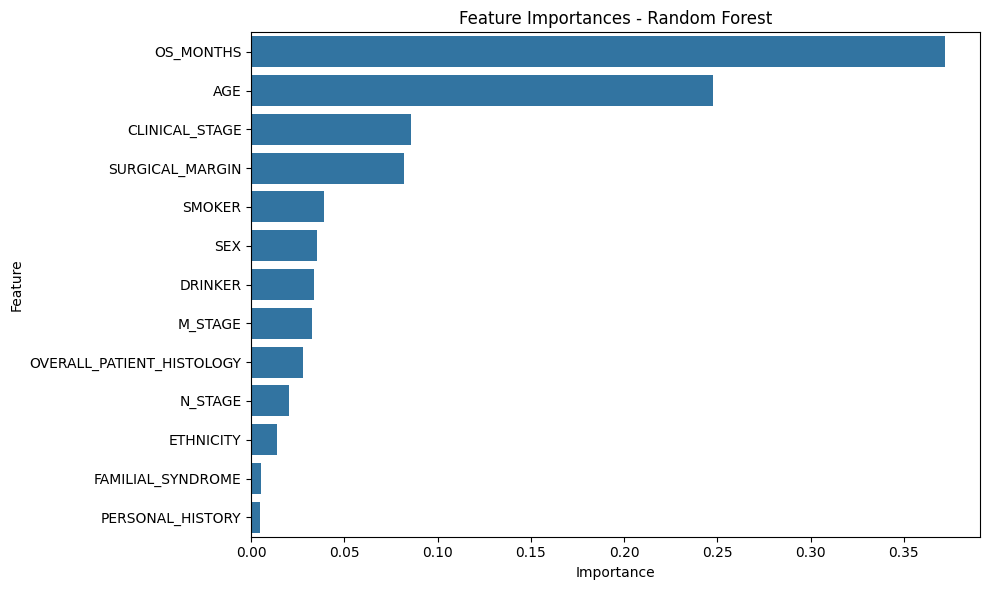

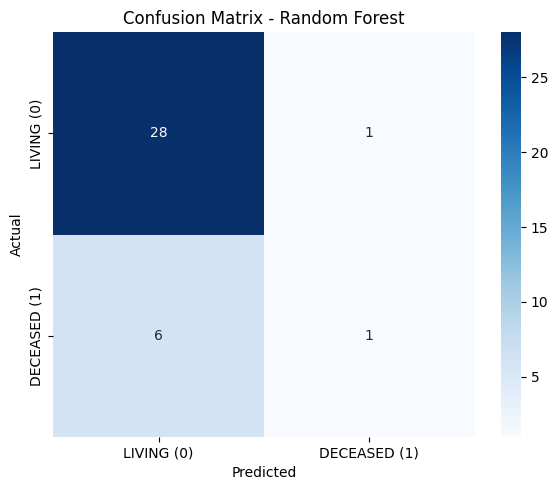

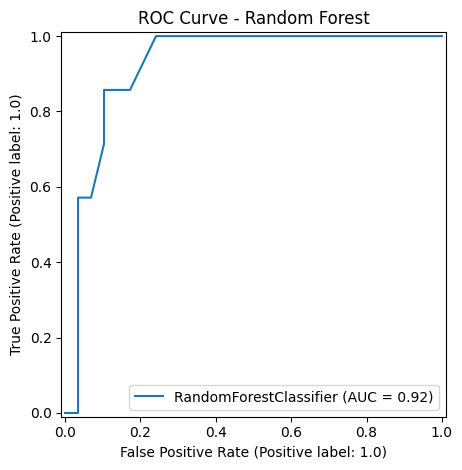


=== Chi-Square Test: Lifestyle vs Outcome ===
SMOKER: p-value = 0.0322 (Significant)
DRINKER: p-value = 0.3549 (Not significant)


In [ ]:
# ============================================================
# NET EARLY DETECTION AI MODEL (Final Project - SAT5114)
# This script builds a complete ML pipeline for predicting
# Neuroendocrine Tumor (NET) survival outcomes using clinical data.
# ============================================================

# === Import essential libraries for data processing ===

import pandas as pd #for data manipulation, such as reading tabular files, filtering columns, merging datasets, and formatting the results.
import numpy as np  #numpy provides efficient handling of numerical data arrays, used for creating NaNs, filling missing values, etc.
import matplotlib.pyplot as plt #for plotting graphs such as feature importance and ROC curves.
import seaborn as sns   #seaborn makes is to draw beautiful plots.

# === Import libraries for model development and evaluation ===

from sklearn.model_selection import train_test_split    #to split datasets into training and testing sets.
from sklearn.preprocessing import LabelEncoder, StandardScaler  # 'LabelEncoder' is used to convert text labels to numerical. 'StandardScaler' helps normalize numerical features (used in logistic regression, SVM, etc.)
from sklearn.impute import SimpleImputer    #used to fill in missing values using a strategy like 'most frequent'.
from sklearn.pipeline import make_pipeline  #it helps us stack transformers and models together (e.g. scaler and model).
from sklearn.ensemble import RandomForestClassifier #it is an ensemble ML method great for feature importance and classification.
from sklearn.linear_model import LogisticRegression #it is a baseline interpretable model often used in medical predictions.
from sklearn.svm import SVC #Support Vector Classifier, powerful with non linear decision boundaries.
from sklearn.neighbors import KNeighborsClassifier  # A simple distance based classifier, easy to understand and implement.
from sklearn.naive_bayes import GaussianNB  # Based on Bayes theorem, works well with categorical and continuous features.
from scipy.stats import chi2_contingency # Chi square test tells us if two categorical variables are statistically related.
from sklearn.metrics import (   #These metrics help evaluate how good the model's predictions are.
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, RocCurveDisplay
)

#Suppresses warnings in output for cleaner display.
import warnings
warnings.filterwarnings("ignore")

# === STEP 1: Load the two NET datasets from file paths ===

file_2018 = "./panet_msk_2018/data_clinical_patient.txt"
file_2017 = "./panet_arcnet_2017/data_clinical_patient.txt"

#This function skips comment lines at the start of each file
def load_dataset(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()
    header_index = next(i for i, line in enumerate(lines) if not line.startswith("#"))
    return pd.read_csv(file_path, sep="\t", skiprows=header_index)

# Load datasets
with open(file_2018, 'r') as f1:
    lines_2018 = f1.readlines()
header_2018 = next(i for i, line in enumerate(lines_2018) if not line.startswith("#"))
df_2018 = pd.read_csv(file_2018, sep="\t", skiprows=header_2018)

with open(file_2017, 'r') as f2:
    lines_2017 = f2.readlines()
header_2017 = next(i for i, line in enumerate(lines_2017) if not line.startswith("#"))
df_2017 = pd.read_csv(file_2017, sep="\t", skiprows=header_2017)

# === STEP 2: Prepare and merge both datasets with a common schema ===

#These are the key features used across datasets
common_features = [
    'SEX', 'AGE', 'ETHNICITY', 'SMOKER', 'DRINKER',
    'CLINICAL_STAGE', 'N_STAGE', 'M_STAGE', 'SURGICAL_MARGIN',
    'OVERALL_PATIENT_HISTOLOGY', 'FAMILIAL_SYNDROME', 'PERSONAL_HISTORY',
    'OS_STATUS', 'OS_MONTHS'
]

#Retain common columns and add any missing ones with 'NaNs'
df_2018 = df_2018[[col for col in common_features if col in df_2018.columns]].copy()
df_2017 = df_2017[[col for col in common_features if col in df_2017.columns]].copy()

for col in common_features:
    if col not in df_2018.columns:
        df_2018[col] = np.nan
    if col not in df_2017.columns:
        df_2017[col] = np.nan

#Merge both datasets into one full dataset
df_merged = pd.concat([df_2018, df_2017], ignore_index=True)

# === STEP 3: Clean and preprocess the data ===

#Convert outcome column to binary format: 1 = DECEASED, 0 = LIVING
target = 'OS_STATUS'
df_merged[target] = df_merged[target].apply(lambda x: 1 if 'DECEASED' in str(x) else 0)

#Encode categorical columns using LabelEncoder
cat_features = df_merged.select_dtypes(include='object').columns.tolist()
encoders = {col: LabelEncoder().fit(df_merged[col].astype(str)) for col in cat_features}
for col, encoder in encoders.items():
    df_merged[col] = encoder.transform(df_merged[col].astype(str))

#Fill any missing values using the most frequent (mode) strategy
imputer = SimpleImputer(strategy='most_frequent')
df_merged_imputed = pd.DataFrame(imputer.fit_transform(df_merged), columns=df_merged.columns)

# === STEP 4: Split data into training and test sets ===

X = df_merged_imputed.drop(columns=[target])  #Features
y = df_merged_imputed[target]                #Target variable

# Use 80/20 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === STEP 5: Define multiple models to compare ===

# Define a dictionary of ML models to compare. These include:
# Logistic Regression: linear baseline model
# Random Forest: ensemble decision tree model that is robust to overfitting
# SVM : kernel-based classifier that handles non-linear boundaries
# KNN: simple, instance-based learner relying on distance
# Naive Bayes: probability-based classifier using Bayes theorem
# Models that require feature scaling are embedded in pipelines with StandardScaler.

models = {
    "Logistic Regression": make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, class_weight='balanced')),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
    "SVM": make_pipeline(StandardScaler(), SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=42)),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
    "Naive Bayes": GaussianNB()
}

# === STEP 6: Train models and collect evaluation metrics ===

# Loop through each model, train it on the training dataset,
# and collect various evaluation metrics for both train and test data.

train_results, test_results = [], []
model_objects = {}

for name, model in models.items():
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_train_proba = model.predict_proba(X_train)[:, 1] if hasattr(model, "predict_proba") else np.zeros_like(y_train_pred)
    y_test_pred = model.predict(X_test)
    y_test_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else np.zeros_like(y_test_pred)

    train_results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_train, y_train_pred),
        "Precision": precision_score(y_train, y_train_pred),
        "Recall": recall_score(y_train, y_train_pred),
        "F1-Score": f1_score(y_train, y_train_pred),
        "AUC-ROC": roc_auc_score(y_train, y_train_proba)
    })

    test_results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_test_pred),
        "Precision": precision_score(y_test, y_test_pred),
        "Recall": recall_score(y_test, y_test_pred),
        "F1-Score": f1_score(y_test, y_test_pred),
        "AUC-ROC": roc_auc_score(y_test, y_test_proba)
    })

    model_objects[name] = (model, y_test_pred, y_test_proba)

# === STEP 7: Display performance metrics ===

# Convert the results into DataFrames for clean tabular viewing.
train_df = pd.DataFrame(train_results).sort_values(by='AUC-ROC', ascending=False)
test_df = pd.DataFrame(test_results).sort_values(by='AUC-ROC', ascending=False)

print("\n=== Training Set Performance ===\n")
print(train_df)
print("\n=== Test Set Performance ===\n")
print(test_df)

# === STEP 8: Visualize feature importance (only for Random Forest) ===

# Extract and visualize the feature importances from the trained Random Forest model.
# This helps understand which input variables most influence the prediction outcome.

rf_model = model_objects["Random Forest"][0]
importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title("Feature Importances - Random Forest")
plt.tight_layout()
plt.show()

# === STEP 9: Confusion Matrix and ROC Curve for Best Model ===

# Select the best-performing model from test results based on AUC-ROC.
# Plot confusion matrix to visualize classification results (TP, TN, FP, FN).
# Plot ROC curve to illustrate the model’s discrimination ability.

best_model_name = test_df.iloc[0]['Model']
best_model, best_pred, _ = model_objects[best_model_name]

conf_matrix = confusion_matrix(y_test, best_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['LIVING (0)', 'DECEASED (1)'],
            yticklabels=['LIVING (0)', 'DECEASED (1)'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix - {best_model_name}")
plt.tight_layout()
plt.show()

RocCurveDisplay.from_estimator(best_model, X_test, y_test)
plt.title(f"ROC Curve - {best_model_name}")
plt.tight_layout()
plt.show()

# === STEP 10: Chi-Square Tests for Lifestyle Variables ===

# Apply chi-square test of independence to assess the relationship
# between lifestyle features (SMOKER and DRINKER) and the survival outcome (OS_STATUS).
# A low p-value (< 0.05) suggests that the feature is statistically associated with the target.

print("\n=== Chi-Square Test: Lifestyle vs Outcome ===")
for feature in ['SMOKER', 'DRINKER']:
    table = pd.crosstab(df_merged_imputed[feature], df_merged_imputed['OS_STATUS'])
    chi2, p, _, _ = chi2_contingency(table)
    print(f"{feature}: p-value = {p:.4f} {'(Significant)' if p < 0.05 else '(Not significant)'}")
